# Using PyTorch for simple regression

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/2.pytorch-nn-training-cars.ipynb)

By [Terence Parr](https://explained.ai).

Once we can implement our own gradient descent using pytorch autograd and matrix algebra, it's time to graduate to using pytorch's built-in neural network module and the built-in optimizers (e.g., Adam). Next, we observe how a sequence of two linear models is effectively the same as a single linear model. After we add a nonlinearity, we see more sophisticated curve fitting. Then we see how a sequence of multiple linear units plus nonlinearities affects predictions. Finally, we see what happens if we give a model too much power: the regression curve over fits the training data.

## Support code

In [30]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import tsensor

In [31]:
def carshow(m, b, X, y, file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.plot(X, m * X + b, lw=.5, color='black')
    ax.set_title(f"$y = {m:.3f}x + {b:.2f}$")
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")

    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
    
    plt.show()

def mshow(model, X, y, file=None):
    fig, ax = plt.subplots(figsize=(4,3))

    with torch.no_grad():
        y_pred = model(X)
    ax.scatter(X, y, s=15, color='#F46C43', alpha=.5)
    ax.scatter(X, y_pred, lw=.5, color='black', s=1)
    if sum(X)/len(X)<1.0:
        ax.set_xlabel("Weight (Standardized)")
    else:
        ax.set_xlabel("Weight")
    ax.set_ylabel("MPG")
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
    plt.show()

## Load simple data set

In [32]:
df_cars = pd.read_csv("data/cars.csv")
df_cars.head(2)

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693


In [33]:
n = len(df_cars)
X = torch.tensor(df_cars.WGT).float().reshape(n,1)
X = (X-torch.mean(X))/torch.std(X)
y = torch.tensor(df_cars.MPG).reshape(n,1)

## Pytorch built-in linear model

Epoch   0 MSE loss      660.965 MAE    24.29
Epoch  10 MSE loss      229.947 MAE    14.48
Epoch  20 MSE loss       55.723 MAE     6.22
Epoch  30 MSE loss       19.793 MAE     3.32
Epoch  40 MSE loss       23.428 MAE     3.94
Epoch  50 MSE loss       22.154 MAE     3.78
Epoch  60 MSE loss       19.078 MAE     3.36
Epoch  70 MSE loss       18.756 MAE     3.28
LAST      MSE loss       18.756 MAE     3.28


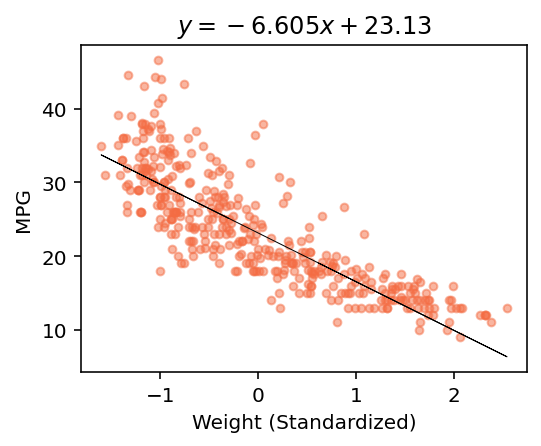

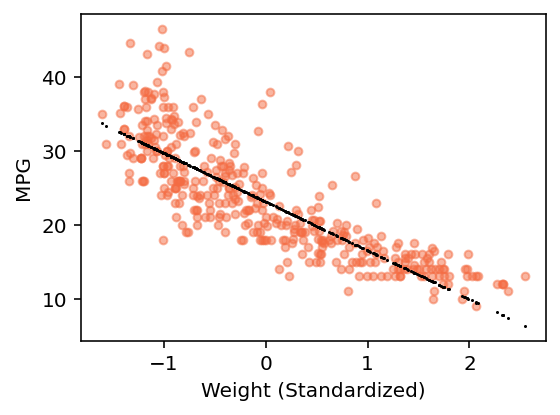

In [45]:
model = nn.Linear(1, 1) # each instance has 1 value, spit out 1 value

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
nepochs=70
for epoch in range(nepochs+1):
    with tsensor.clarify():
        y_pred = model(X)
    loss = torch.mean((y_pred - y)**2)
    if epoch % 10 == 0:
        with torch.no_grad():
            mae = torch.mean(torch.abs(y_pred - y))
            print(f"Epoch {epoch:3d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

    # Backprop to compute gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # adjust weights
    
m = model.weight.detach().item()
b = model.bias.detach().item()
print(f"LAST      MSE loss {loss:12.3f} MAE {mae:8.2f}")

carshow(m, b, X=X, y=df_cars.MPG)
mshow(model, X=X, y=df_cars.MPG)

## Factor out a training method

In [35]:
def train(model, learning_rate = .5, nepochs=2000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(nepochs+1):
        y_pred = model(X)
        loss = torch.mean((y_pred - y)**2)
        if epoch % (nepochs//10) == 0:
            with torch.no_grad():
                mae = torch.mean(torch.abs(y_pred - y))
                print(f"Epoch {epoch:4d} MSE loss {loss:12.3f} MAE {mae:8.2f}")

        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"LAST       MSE loss {loss:12.3f} MAE {mae:8.2f}")
    return loss

Epoch    0 MSE loss      634.082 MAE    23.88
Epoch    7 MSE loss      305.727 MAE    16.94
Epoch   14 MSE loss      132.910 MAE    10.45
Epoch   21 MSE loss       42.466 MAE     5.27
Epoch   28 MSE loss       20.230 MAE     3.28
Epoch   35 MSE loss       21.544 MAE     3.72
Epoch   42 MSE loss       24.235 MAE     4.01
Epoch   49 MSE loss       22.289 MAE     3.80
Epoch   56 MSE loss       19.711 MAE     3.47
Epoch   63 MSE loss       18.709 MAE     3.29
Epoch   70 MSE loss       18.801 MAE     3.28
LAST       MSE loss       18.801 MAE     3.28


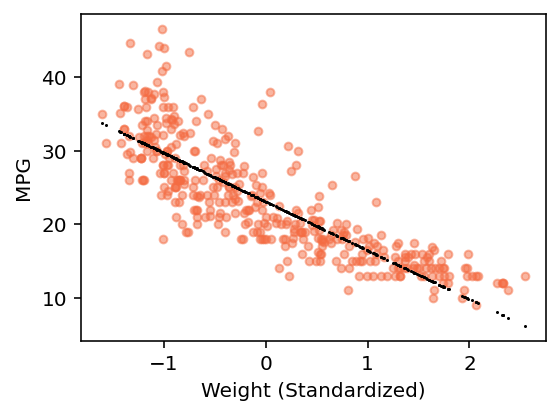

In [36]:
model = nn.Linear(1, 1)

train(model, learning_rate=1, nepochs=70)

mshow(model, X=X, y=df_cars.MPG)

## Sequence of 2 linear models with pytorch

Unless we add relu or sigmoid, 2 models chained is same as one: it's a line.

Let's create a generic training function for given model and a new show function.

### Without nonlinearity

Epoch    0 MSE loss      628.191 MAE    23.89
Epoch   10 MSE loss       31.775 MAE     4.71
Epoch   20 MSE loss       26.241 MAE     4.12
Epoch   30 MSE loss       23.675 MAE     4.02
Epoch   40 MSE loss       20.487 MAE     3.60
Epoch   50 MSE loss       19.225 MAE     3.41
Epoch   60 MSE loss       18.690 MAE     3.29
Epoch   70 MSE loss       18.758 MAE     3.26
Epoch   80 MSE loss       18.687 MAE     3.27
Epoch   90 MSE loss       18.690 MAE     3.29
Epoch  100 MSE loss       18.680 MAE     3.27
LAST       MSE loss       18.680 MAE     3.27


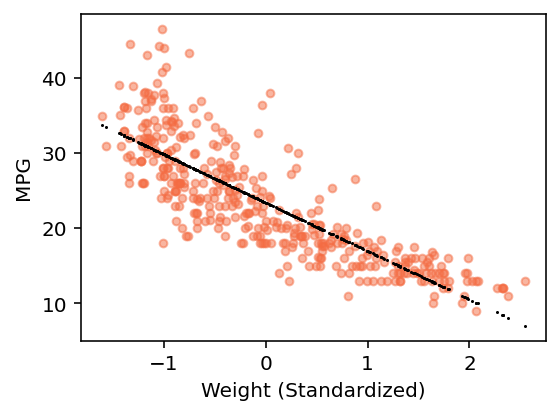

In [37]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Linear(1, 1)
)

train(model, learning_rate=2.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="2linear")

### With ReLU nonlinearity

Epoch    0 MSE loss      637.427 MAE    23.93
Epoch   10 MSE loss      248.144 MAE    13.30
Epoch   20 MSE loss       93.009 MAE     7.43
Epoch   30 MSE loss       45.696 MAE     5.52
Epoch   40 MSE loss       29.265 MAE     4.36
Epoch   50 MSE loss       22.332 MAE     3.68
Epoch   60 MSE loss       19.770 MAE     3.40
Epoch   70 MSE loss       19.336 MAE     3.28
Epoch   80 MSE loss       18.893 MAE     3.31
Epoch   90 MSE loss       18.806 MAE     3.27
Epoch  100 MSE loss       18.769 MAE     3.28
LAST       MSE loss       18.769 MAE     3.28


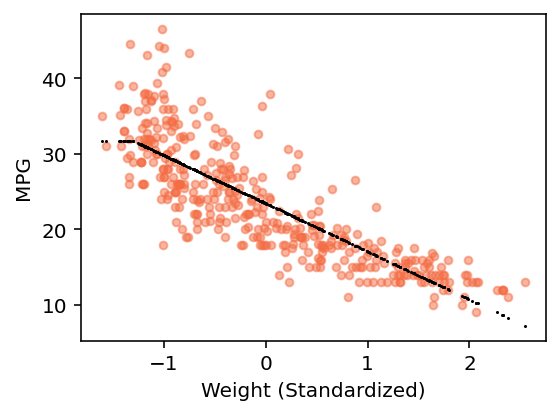

In [38]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.ReLU(),     # add nonlinearity, gives two lines
    nn.Linear(1, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="linRlin")

Epoch    0 MSE loss      596.677 MAE    23.16
Epoch   10 MSE loss       90.790 MAE     8.03
Epoch   20 MSE loss       21.873 MAE     3.57
Epoch   30 MSE loss       20.317 MAE     3.29
Epoch   40 MSE loss       18.410 MAE     3.24
Epoch   50 MSE loss       17.965 MAE     3.21
Epoch   60 MSE loss       17.609 MAE     3.12
Epoch   70 MSE loss       17.464 MAE     3.06
Epoch   80 MSE loss       17.433 MAE     3.06
Epoch   90 MSE loss       17.417 MAE     3.07
Epoch  100 MSE loss       17.407 MAE     3.06
LAST       MSE loss       17.407 MAE     3.06


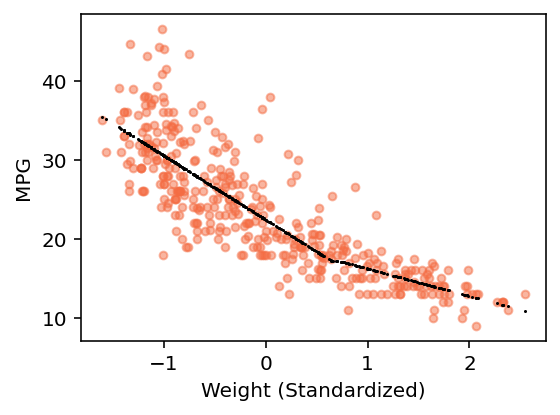

In [39]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin")

Epoch    0 MSE loss      637.499 MAE    24.02
Epoch   10 MSE loss      590.532 MAE    23.02
Epoch   20 MSE loss      545.893 MAE    22.03
Epoch   30 MSE loss      503.797 MAE    21.05
Epoch   40 MSE loss      464.341 MAE    20.09
Epoch   50 MSE loss      427.528 MAE    19.15
Epoch   60 MSE loss      393.300 MAE    18.24
Epoch   70 MSE loss      361.567 MAE    17.34
Epoch   80 MSE loss      332.224 MAE    16.48
Epoch   90 MSE loss      305.157 MAE    15.63
Epoch  100 MSE loss      280.252 MAE    14.82
LAST       MSE loss      280.252 MAE    14.82


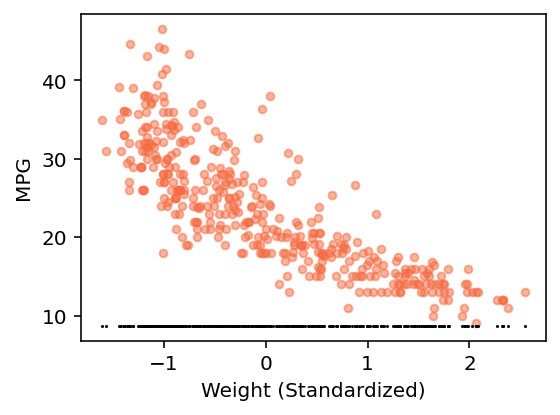

In [40]:
model = nn.Sequential(
    nn.Linear(1, 5),
    nn.ReLU(),
    nn.Linear(5, 2),
    nn.ReLU(),
    nn.Linear(2, 1)
)

train(model, learning_rate=.1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file="lin5Rlin2")

### What matrix algebra is that model doing?

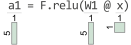

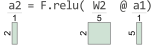

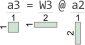

In [41]:
# Draw matrix shapes
import torch.nn.functional as F
import tsensor

W1 = torch.rand(5,1)
W2 = torch.rand(2,5)
W3 = torch.rand(1,2)
x = torch.rand(1,1)
with tsensor.explain() as e:
    a1 = F.relu(W1 @ x)
    a2 = F.relu(W2 @ a1)
    a3 = W3 @ a2

### With logistic function (sigmoid) nonlinearity

Epoch    0 MSE loss      629.684 MAE    23.86
Epoch   10 MSE loss       81.077 MAE     7.03
Epoch   20 MSE loss       92.066 MAE     8.15
Epoch   30 MSE loss       67.044 MAE     6.94
Epoch   40 MSE loss       64.178 MAE     6.56
Epoch   50 MSE loss       61.533 MAE     6.52
Epoch   60 MSE loss       61.370 MAE     6.61
Epoch   70 MSE loss       60.785 MAE     6.55
Epoch   80 MSE loss       60.867 MAE     6.53
Epoch   90 MSE loss       60.770 MAE     6.55
Epoch  100 MSE loss       60.771 MAE     6.55
LAST       MSE loss       60.771 MAE     6.55


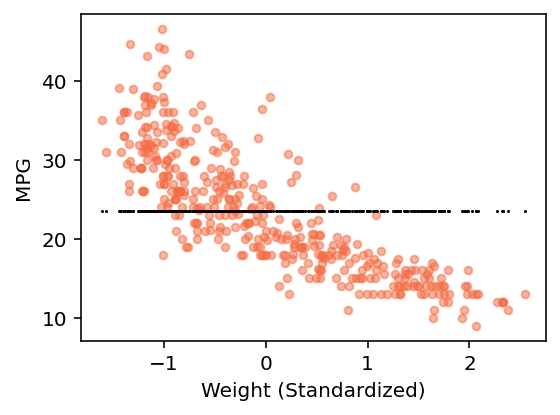

In [42]:
model = nn.Sequential(
    nn.Linear(1, 1), # each instance has 1 value, spit out 1 values
    nn.Sigmoid(),    # doesn't converge as fast; bump learning rate
    nn.Linear(1, 1)
)

train(model, learning_rate=1, nepochs=100)

mshow(model, X=X, y=df_cars.MPG, file='linSlin')

## Overfitting with a two-layer pytorch network

Epoch    0 MSE loss      607.696 MAE    23.45
Epoch  200 MSE loss       17.112 MAE     3.04
Epoch  400 MSE loss       16.921 MAE     3.03
Epoch  600 MSE loss       16.682 MAE     3.01
Epoch  800 MSE loss       16.575 MAE     2.98
Epoch 1000 MSE loss       16.551 MAE     2.98
Epoch 1200 MSE loss       16.541 MAE     3.00
Epoch 1400 MSE loss       16.839 MAE     2.95
Epoch 1600 MSE loss       16.718 MAE     2.95
Epoch 1800 MSE loss       16.538 MAE     3.01
Epoch 2000 MSE loss       16.495 MAE     2.97
LAST       MSE loss       16.495 MAE     2.97


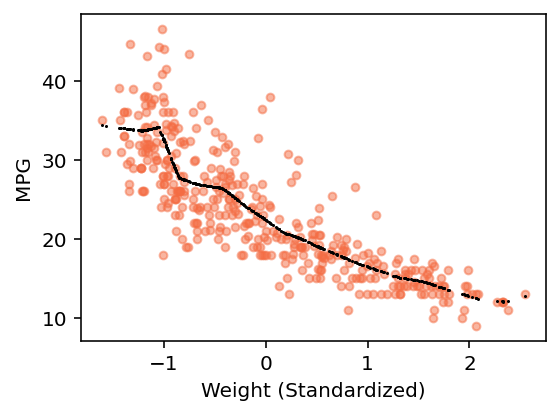

In [43]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.ReLU(),          # fast to compute, not smooth y_pred
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1)

mshow(model, X=X, y=df_cars.MPG, file="lin1kRlin")

Epoch    0 MSE loss      607.190 MAE    23.40
Epoch  150 MSE loss       17.361 MAE     3.08
Epoch  300 MSE loss       17.264 MAE     3.05
Epoch  450 MSE loss       17.275 MAE     3.04
Epoch  600 MSE loss       17.126 MAE     3.03
Epoch  750 MSE loss       17.036 MAE     3.01
Epoch  900 MSE loss       16.961 MAE     3.01
Epoch 1050 MSE loss       16.886 MAE     3.00
Epoch 1200 MSE loss       19.697 MAE     3.44
Epoch 1350 MSE loss       16.817 MAE     3.00
Epoch 1500 MSE loss       16.807 MAE     3.01
LAST       MSE loss       16.807 MAE     3.01


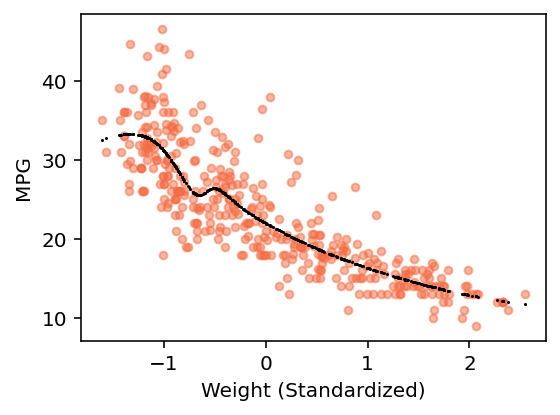

In [44]:
model = nn.Sequential(
    nn.Linear(1, 1000), # each instance has 1 value, spit out 1000 values
    nn.Tanh(),          # add nonlinearity
    nn.Linear(1000, 1)
)

train(model, learning_rate=.1, nepochs=1500)

mshow(model, X=X, y=df_cars.MPG)